In [ ]:
# XGBoost Regression Model for Character Bid Prediction
# This notebook builds a regression model using XGBoost to predict the bid prices of characters based on their attributes. We'll use the characters.db SQLite database which contains scraped character auction data.

In [1]:
# Import required libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

# Set random seed for reproducibility
np.random.seed(42)

In [95]:
# Connect to the SQLite database
conn = sqlite3.connect('../data/characters.db')

# Read the characters data into a DataFrame
query = "SELECT * FROM characters WHERE status LIKE '%finished%'"
df = pd.read_sql_query(query, conn)

# Close the connection
conn.close()

# Print the dataset shape
print(f"Dataset shape: {df.shape}")

# Display the first few rows of the dataset
df.head()

Dataset shape: (535586, 35)


,id,name,status,bid,level,vocation,server,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,auction_start_date_iso,auction_end_date_iso,imbuements,charms
0,5,Areczekk,finished,201,37,paladin,Antica,0,13,13,85,10,10,11,74,13,1,11,21080,0,1,30,0,0,0,0,0,9,0,0,0,2020-08-26T10:06:00,2020-08-27T10:00:00,0,0
1,13,Alot of Ketchup,finished,1000,150,paladin,Thyria,0,13,13,72,10,10,20,58,15,0,11,0,3,1,40,0,0,0,0,0,4,0,0,0,2020-08-26T10:05:00,2020-09-01T10:00:00,0,0
2,16,Mad Healer,finished,2500,266,druid,Epoca,0,14,20,21,43,19,89,33,22,16,28,3131,390,1,75,0,0,0,0,0,2,0,0,0,2020-08-26T10:06:00,2020-09-24T10:00:00,3,0
3,23,Aj Dzi,finished,521,110,sorcerer,Damora,0,12,12,12,10,10,68,33,12,1,11,1542,0,1,185,0,0,0,0,0,19,0,0,0,2020-08-26T10:05:00,2020-08-27T10:00:00,0,0
4,25,Obahowsky,finished,102,8,sorcerer,Refugia,0,12,12,18,10,10,70,35,13,0,11,1260,0,1,0,0,0,0,0,0,8,0,0,0,2020-08-26T10:04:00,2020-09-24T10:00:00,0,0


In [96]:

# Insert servers.json data into the DataFrame
servers_df = pd.read_json('../data/servers.json')
# Merge the servers data with the characters data

# Process servers.json data into a more usable dataframe format
server_data_list = []

# Convert the wide JSON format to a long format
for column in servers_df.columns:
    server_info = servers_df[column]
    
    # Extract data from each server
    server_data = {
        'server_name': server_info['serverName'],
        'server_location': server_info['serverLocation']['string'],
        'pvp_type': server_info['pvpType']['string'],
        'battleye': server_info['battleye'],
        'experimental': server_info['experimental']
    }
    server_data_list.append(server_data)

# Create a new dataframe with server details
servers_df_processed = pd.DataFrame(server_data_list)

# Rename server_name column to match the 'server' column in the characters dataframe
servers_df_processed = servers_df_processed.rename(columns={'server_name': 'server', 'experimental': 'server_experimental'})


servers_df_processed.head()

# Merge the servers data with the characters data
df = df.merge(servers_df_processed, on='server', suffixes=('', '_drop'))
df = df[[col for col in df.columns if not col.endswith('_drop')]]

df.head()


,id,name,status,bid,level,vocation,server,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,auction_start_date_iso,auction_end_date_iso,imbuements,charms,server_location,pvp_type,battleye,server_experimental
0,5,Areczekk,finished,201,37,paladin,Antica,0,13,13,85,10,10,11,74,13,1,11,21080,0,1,30,0,0,0,0,0,9,0,0,0,2020-08-26T10:06:00,2020-08-27T10:00:00,0,0,EU,Open,False,False
1,13,Alot of Ketchup,finished,1000,150,paladin,Thyria,0,13,13,72,10,10,20,58,15,0,11,0,3,1,40,0,0,0,0,0,4,0,0,0,2020-08-26T10:05:00,2020-09-01T10:00:00,0,0,EU,Open,False,False
2,16,Mad Healer,finished,2500,266,druid,Epoca,0,14,20,21,43,19,89,33,22,16,28,3131,390,1,75,0,0,0,0,0,2,0,0,0,2020-08-26T10:06:00,2020-09-24T10:00:00,3,0,EU,Retro Open,False,False
3,23,Aj Dzi,finished,521,110,sorcerer,Damora,0,12,12,12,10,10,68,33,12,1,11,1542,0,1,185,0,0,0,0,0,19,0,0,0,2020-08-26T10:05:00,2020-08-27T10:00:00,0,0,EU,Optional,True,False
4,25,Obahowsky,finished,102,8,sorcerer,Refugia,0,12,12,18,10,10,70,35,13,0,11,1260,0,1,0,0,0,0,0,0,8,0,0,0,2020-08-26T10:04:00,2020-09-24T10:00:00,0,0,EU,Optional,False,False


In [85]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

# Get basic statistics of numerical features
print("\nBasic statistics:")
df.describe()

Missing values per column:
id                                    0
name                                  0
status                                0
bid                                   0
level                                 0
vocation                              0
server                                0
is_name_contains_special_character    0
axe_fighting                          0
club_fighting                         0
distance_fighting                     0
fishing                               0
fist_fighting                         0
magic_level                           0
shielding                             0
sword_fighting                        0
mounts                                0
outfits                               0
gold                                  0
achievement_points                    0
is_transfer_available                 0
available_charm_points                0
spent_charm_points                    0
charm_expansion                       0
hunting_task_

,id,bid,level,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,imbuements,charms
count,535586.000000,5.355860e+05,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,5.355860e+05,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000,535586.000000
mean,533839.652019,5.855234e+03,248.966534,0.003015,24.222622,21.611530,42.176648,14.521759,13.648740,45.365932,67.891917,32.239610,5.672294,17.170486,1.882807e+05,32.649302,0.970115,249.140500,1064.247572,0.049635,668.867694,0.004334,0.117824,22.678954,0.022269,0.029909,0.002371,5.343898,1.378061
std,285248.586482,1.368249e+06,206.528542,0.054830,26.827795,21.706127,42.141379,9.964980,5.268325,35.005415,33.390638,32.883831,7.900040,7.143681,2.096876e+06,98.245442,0.170270,305.401428,1836.058326,0.217191,2713.196265,0.065687,0.322522,18.734982,0.176504,0.258987,0.059827,8.374555,2.225001
min,5.000000,5.700000e+01,8.000000,0.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,10.000000,10.000000,0.000000,11.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,286809.500000,2.500000e+02,95.000000,0.000000,12.000000,12.000000,13.000000,10.000000,10.000000,11.000000,33.000000,13.000000,1.000000,11.000000,2.342000e+03,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,555522.000000,8.010000e+02,189.000000,0.000000,13.000000,14.000000,19.000000,10.000000,12.000000,31.000000,82.000000,16.000000,2.000000,15.000000,2.698800e+04,0.000000,1.000000,145.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,793810.750000,3.000000e+03,350.000000,0.000000,17.000000,17.000000,96.000000,12.000000,15.000000,76.000000,100.000000,32.000000,7.000000,21.000000,1.347120e+05,0.000000,1.000000,385.000000,1400.000000,0.000000,270.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.000000,9.000000,2.000000
max,969999.000000,1.000000e+09,1859.000000,1.000000,138.000000,134.000000,140.000000,102.000000,114.000000,142.000000,128.000000,138.000000,87.000000,75.000000,1.015917e+09,1266.000000,1.000000,8620.000000,17400.000000,1.000000,191279.000000,1.000000,2.000000,53.000000,10.000000,4.000000,6.000000,24.000000,19.000000


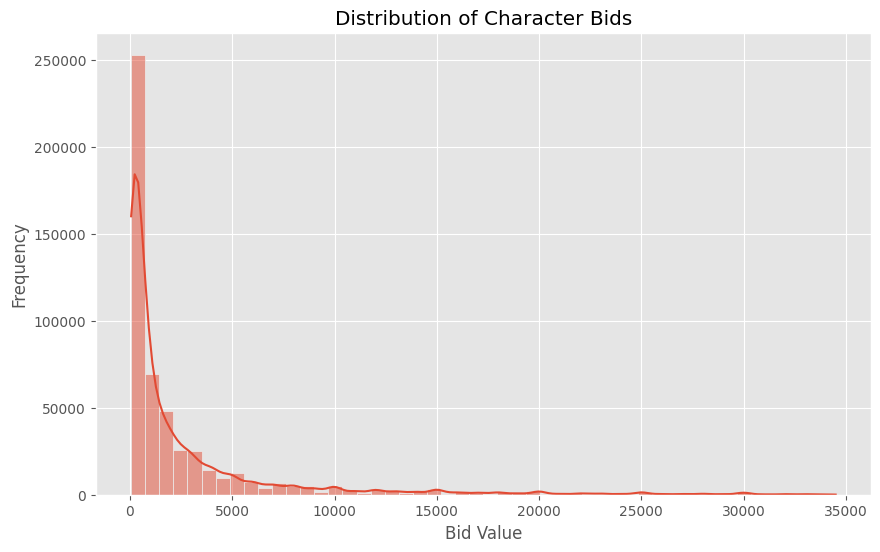

KeyboardInterrupt: 

In [80]:
# Visualize the distribution of bids
plt.figure(figsize=(10, 6))
# Calculate the 99th percentile to exclude extreme outliers
bid_99_percentile = np.percentile(df['bid'], 99)
# Plot histogram with values up to 99th percentile
sns.histplot(df[df['bid'] <= bid_99_percentile]['bid'], kde=True, bins=50)
plt.title('Distribution of Character Bids')
plt.xlabel('Bid Value')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between level and bid
plt.figure(figsize=(10, 6))
# Filter out extreme bid values for the scatter plot as well
df_filtered = df[df['bid'] <= bid_99_percentile]
sns.scatterplot(x='level', y='bid', hue='vocation', data=df_filtered)
plt.title('Character Level vs Bid by Vocation')
plt.xlabel('Character Level')
plt.ylabel('Bid Value')
plt.show()

# Create correlation matrix for numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numerical_cols].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [97]:
# Feature Engineering and Data Preparation

# Convert date columns to datetime objects and extract features if needed
df['auction_start_date'] = pd.to_datetime(df['auction_start_date_iso'])
df['auction_end_date'] = pd.to_datetime(df['auction_end_date_iso'])
df['auction_duration_hours'] = (df['auction_end_date'] - df['auction_start_date']).dt.total_seconds() / 3600



# Clean data by removing outliers
# Filter out extreme bid values (>99th percentile)
df = df[df['bid'] <= bid_99_percentile]


# Create a feature for auction time of day (could affect bidding behavior)
df['auction_hour'] = df['auction_start_date'].dt.hour
df['auction_day_of_week'] = df['auction_start_date'].dt.dayofweek

# Add Volume of Bids last week and last month for that server
df['bid_volume_last_7_days'] = df['server'].map(df[df['auction_end_date_iso'].astype('datetime64[ns]') >= pd.Timestamp.now() - pd.Timedelta(days=7)].groupby('server')['bid'].sum()).fillna(0)


# Define features and target variable
X = df.drop(['id', 'name', 'status', 'bid', 'auction_start_date_iso', 'auction_end_date_iso', 
              'auction_start_date', 'auction_end_date'], axis=1)
y = df['bid']

# Print remaining feature columns
print(f"Feature columns ({len(X.columns)}):\n{X.columns.tolist()}")
print(f"Target variable: bid")

Feature columns (37):
['level', 'vocation', 'server', 'is_name_contains_special_character', 'axe_fighting', 'club_fighting', 'distance_fighting', 'fishing', 'fist_fighting', 'magic_level', 'shielding', 'sword_fighting', 'mounts', 'outfits', 'gold', 'achievement_points', 'is_transfer_available', 'available_charm_points', 'spent_charm_points', 'charm_expansion', 'hunting_task_points', 'permanent_prey_task_slot', 'permanent_hunt_task_slot', 'prey_wildcards', 'hirelings', 'hirelings_jobs', 'hirelings_outfits', 'imbuements', 'charms', 'server_location', 'pvp_type', 'battleye', 'server_experimental', 'auction_duration_hours', 'auction_hour', 'auction_day_of_week', 'bid_volume_last_7_days']
Target variable: bid


In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Identify categorical columns for preprocessing
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"\nNumerical columns: {len(numerical_cols)}")

X_train.head()

Training set shape: (367605, 37)
Testing set shape: (157545, 37)

Categorical columns: ['vocation', 'server', 'server_location', 'pvp_type', 'battleye', 'server_experimental']

Numerical columns: 29


,level,vocation,server,is_name_contains_special_character,axe_fighting,club_fighting,distance_fighting,fishing,fist_fighting,magic_level,shielding,sword_fighting,mounts,outfits,gold,achievement_points,is_transfer_available,available_charm_points,spent_charm_points,charm_expansion,hunting_task_points,permanent_prey_task_slot,permanent_hunt_task_slot,prey_wildcards,hirelings,hirelings_jobs,hirelings_outfits,imbuements,charms,server_location,pvp_type,battleye,server_experimental,auction_duration_hours,auction_hour,auction_day_of_week,bid_volume_last_7_days
226631,94,sorcerer,Impulsa,0,10,10,10,10,13,59,30,10,0,11,383170,0,1,25,0,0,0,0,0,53,0,0,0,0,0,EU,Retro Open,True,False,23.900000,10,0,0.0
61656,143,paladin,Talera,0,14,14,105,10,11,21,94,16,5,11,0,0,1,175,0,0,0,0,0,32,0,0,0,0,0,NA,Open,False,False,23.833333,10,0,0.0
214145,353,knight,Secura,0,13,13,12,25,19,10,94,101,14,21,327,0,1,238,3200,0,3157,0,1,19,0,0,0,22,4,EU,Optional,False,False,47.900000,10,3,0.0
519093,9,druid,Belobra,0,13,18,13,10,10,74,35,14,1,11,170750,2,1,0,0,0,0,0,0,53,0,0,0,0,0,BR,Optional,False,False,23.900000,10,2,0.0
57870,203,sorcerer,Pacera,0,17,12,17,10,11,85,35,18,2,13,159424,0,1,351,0,0,0,0,0,21,0,0,0,0,0,NA,Optional,False,False,23.916667,10,3,0.0


In [100]:
# Create preprocessing transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Preprocess the training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
feature_names = (numerical_cols + 
                preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist())

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")

Processed training data shape: (367605, 131)
Processed testing data shape: (157545, 131)


In [205]:
# Initialize and train the XGBoost regressor

# {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.9}

model = xgb.XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=5,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    device="cuda",
    # booster='dart',
)

# Train the model
model.fit(X_train_processed, y_train)

# Make predictions
y_train_pred = model.predict(X_train_processed)
y_test_pred = model.predict(X_test_processed)

In [208]:
# Evaluate the model
def evaluate_model(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{dataset_name} Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R-squared (R²): {r2:.4f}")
    print()

# Evaluate on training data
evaluate_model(y_train, y_train_pred, "Training")

# Evaluate on testing data
evaluate_model(y_test, y_test_pred, "Testing")

Training Metrics:
Mean Squared Error (MSE): 1539347.38
Root Mean Squared Error (RMSE): 1240.70
Mean Absolute Error (MAE): 619.59
R-squared (R²): 0.9328

Testing Metrics:
Mean Squared Error (MSE): 2695292.00
Root Mean Squared Error (RMSE): 1641.73
Mean Absolute Error (MAE): 746.09
R-squared (R²): 0.8810



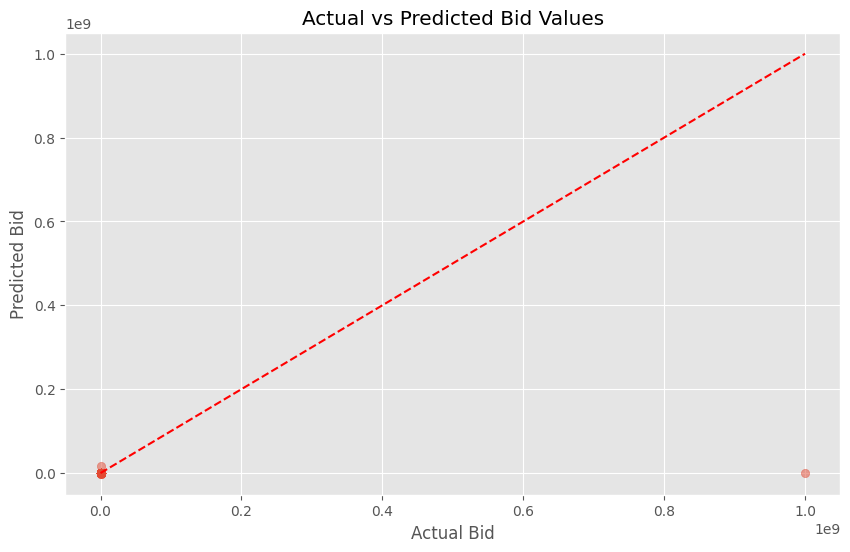

KeyboardInterrupt: 

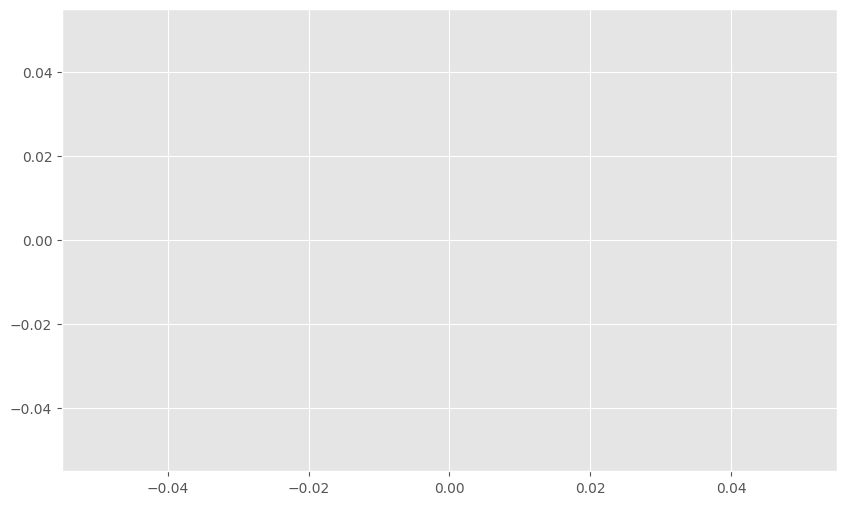

In [22]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Bid')
plt.ylabel('Predicted Bid')
plt.title('Actual vs Predicted Bid Values')
plt.show()

# Visualize residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

# Visualize residuals vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

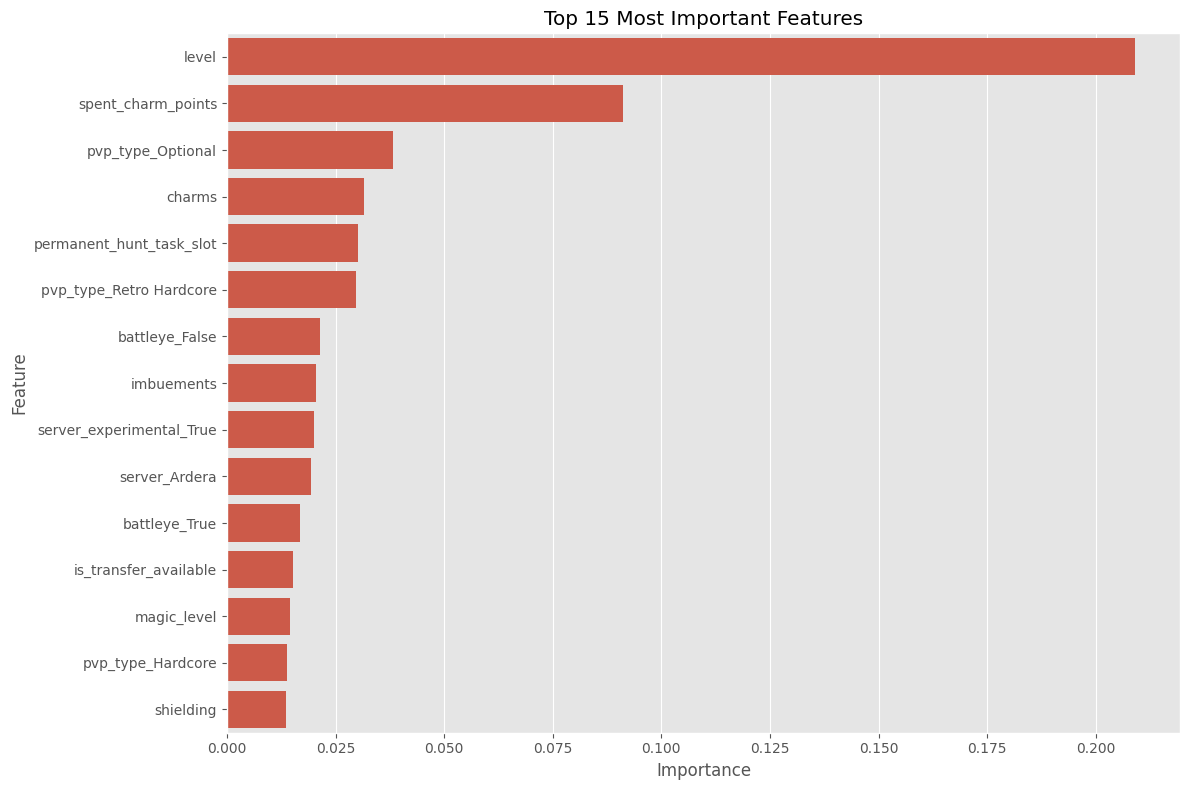

In [209]:
# Get feature importance
importance = model.feature_importances_

# Only use the actual number of features used in the model
feature_importance = pd.DataFrame({
    'Feature': feature_names[:len(importance)],
    'Importance': importance
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

In [182]:
# Optional: Hyperparameter tuning with cross-validation
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Uncomment to run grid search (may take some time)

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    random_state=42, 
)
grid_search = GridSearchCV(
    estimator=xgb_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_processed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

# Train model with best parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_processed)
evaluate_model(y_test, y_pred_best, "Best Model Testing")


Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=   9.5s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=   9.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  11.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.8; total time=  10.9s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.7; total time=  11.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, subsample=0.9; to

In [ ]:
# Save the trained model
import pickle

# Save the model
model_filename = '../models/xgboost_character_bid_model.pkl'

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(model_filename), exist_ok=True)

# Save both the model and the preprocessor
with open(model_filename, 'wb') as f:
    pickle.dump({'model': model, 'preprocessor': preprocessor}, f)

print(f"Model saved to {model_filename}")

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.9}
Best score: 2696685.2


In [132]:
# Function to make predictions for new characters
def predict_character_bid(character_data):
    # Convert to DataFrame if not already
    if not isinstance(character_data, pd.DataFrame):
        character_data = pd.DataFrame([character_data])
    
    # Preprocess the data
    X_new = preprocessor.transform(character_data)
    
    # Make predictions
    predictions = model.predict(X_new)
    
    return predictions[0]

# Example: Create a sample character to predict its bid
# Replace with actual data based on your database schema
sample_character = X_test.iloc[0].copy()  # Take a random sample from the test set

# Display sample character
print("Sample character features:")
for col, val in sample_character.items():
    print(f"{col}: {val}")

# Predict bid
predicted_bid = predict_character_bid(sample_character.to_frame().T)
print(f"\nPredicted bid: {predicted_bid:.2f}")
print(f"Actual bid: {y_test.iloc[0]:.2f}")

Sample character features:
level: 125
server: Celebra
is_name_contains_special_character: 0
axe_fighting: 19
club_fighting: 12
distance_fighting: 14
fishing: 10
magic_level: 70
shielding: 31
sword_fighting: 11
mounts: 1
outfits: 15
gold: 80359
achievement_points: 0
is_transfer_available: 1
available_charm_points: 140
spent_charm_points: 0
charm_expansion: 0
hunting_task_points: 0
permanent_prey_task_slot: 0
permanent_hunt_task_slot: 0
prey_wildcards: 48
hirelings: 0
hirelings_jobs: 0
hirelings_outfits: 0
imbuements: 0
charms: 0
auction_duration_hours: 23.816666666666666
vocation_druid: False
vocation_knight: False
vocation_none: False
vocation_paladin: False
vocation_sorcerer: True
server_suffix_cia: False
server_suffix_dra: False
server_suffix_ela: False
server_suffix_ena: False
server_suffix_era: False
server_suffix_gia: False
server_suffix_ica: False
server_suffix_ima: False
server_suffix_ira: False
server_suffix_lsa: False
server_suffix_mia: False
server_suffix_nia: False
server_su

## Conclusion and Summary

In this notebook, we have:

1. Loaded character data from the SQLite database
2. Performed exploratory data analysis to understand the dataset
3. Engineered features for our regression model
4. Built an XGBoost regression model to predict character bids
5. Evaluated the model's performance using various metrics
6. Identified the most important features for bid prediction
7. Saved the model for future use

The model's performance can be further improved by:

- Fine-tuning hyperparameters using cross-validation
- Engineering additional features based on domain knowledge
- Collecting more data or addressing any class imbalance issues
- Trying different regression algorithms and ensemble methods